### 1b. Extended Detect Ripples and Insert into the Database. [This notebook populates the ExtendedRippleTimes table.]
##### It builds on top of the RippleTimes table, extends each event left and right 200ms, merges overlapping events. Then parse each ripple time decoded replay.
##### The ExtendedRippleTimes table is under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.
##### Only run this after another shijiegu's customized TrialChoice and RippleTimes table is populated.

May 7, 2024
Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os

from spyglass.common.common_interval import _intersection
from spyglass.common import (IntervalPositionInfo, IntervalPositionInfoSelection, IntervalList, 
                             ElectrodeGroup, LFP, BrainRegion, LFPBand, Electrode)
from ripple_detection.core import (gaussian_smooth,
                                   get_envelope,
                                   get_multiunit_population_firing_rate,
                                   threshold_by_zscore,
                                   segment_boolean_series,
                                   exclude_close_events,
                                   exclude_movement,
                                   extend_threshold_to_mean,
                                    merge_overlapping_ranges)
from ripple_detection.detectors import multiunit_HSE_detector,_get_event_stats
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.shijiegu.load import load_spike


[2025-04-10 21:52:44,176][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-10 21:52:44,211][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,DecodeResultsLinear
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,extended_ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import ExtendedRippleTimes,ExtendedTrialChoiceReplay,TetrodeNumber,Decode,ExtendedRippleTimesWithDecode
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

In [4]:
nwb_file_name = 'molly20220416.nwb'
#nwb_file_name = 'eliot20221018.nwb'

### 1. First fill in the EpochPos() table.
This allows faster lookup between epoch/session name and position interval name

In [5]:
nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)

In [6]:
epochs = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')

EpochPos() & {'nwb_file_name': nwb_copy_file_name}

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
molly20220416_ 1         01_Seq2Sleep1  pos 0 valid ti
molly20220416_ 2         02_Seq2Session pos 1 valid ti
molly20220416_ 3         03_Seq2Sleep2  pos 2 valid ti
molly20220416_ 4         04_Seq2Session pos 3 valid ti
molly20220416_ 5         05_Seq2Sleep3  pos 4 valid ti
molly20220416_ 6         06_Seq2Session pos 5 valid ti
molly20220416_ 7         07_Seq2Sleep4  pos 6 valid ti
molly20220416_ 8         08_Seq2Session pos 7 valid ti
molly20220416_ 9         09_Seq2Sleep5  pos 8 valid ti
molly20220416_ 10        10_Seq2Session pos 9 valid ti
molly20220416_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)

In [7]:
run_session = []
for e in epochs:
    epoch_name = (EpochPos() & {'nwb_file_name': nwb_copy_file_name,'epoch':e}).fetch1('epoch_name')
    if epoch_name.split('_')[1][4:8] == 'Sess':
        run_session.append(e)

In [8]:
run_session

[2, 4, 6, 8, 10]

### 1. Run one session. Can skip to 3 directly to run all sessions

In [39]:
epoch_num = run_session[1]
print(epoch_num)

4


In [40]:
epochID = epoch_num
from spyglass.shijiegu.load import load_maze_spike

In [41]:
ripple_times, CA1TetrodeInd, CCTetrodeInd = extended_ripple_detection_master(nwb_file_name,epoch_num)

Using LFP from these eletrodes: 
[ 1  2 11 12 15 16 20 22 24 30]




KeyboardInterrupt: 

In [ ]:
ripple_times

In [89]:
# Insert into database
epoch_name = (EpochPos() & {'nwb_file_name': nwb_copy_file_name ,'epoch':epoch_num}).fetch1('epoch_name')

# for the RippleTimes table
animal = nwb_copy_file_name[:5]
savePath=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                      nwb_copy_file_name+'_'+epoch_name+'_ripple_times.nc')
ripple_times.to_csv(savePath)

# for the RippleTimes table
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}
key['ripple_times'] = savePath
ExtendedRippleTimes().insert1(key,replace = True)

In [90]:
(ExtendedRippleTimes() & {'nwb_file_name': nwb_copy_file_name})

*nwb_file_name *interval_list ripple_tim
+------------+ +------------+ +--------+
lewis20240118_ 01_Rev1Sleep1  =BLOB=    
lewis20240118_ 02_Rev1Session =BLOB=    
lewis20240118_ 03_Rev1Sleep2  =BLOB=    
lewis20240118_ 04_Rev1Session =BLOB=    
lewis20240118_ 05_Rev1Sleep3  =BLOB=    
lewis20240118_ 06_Rev1Session =BLOB=    
lewis20240118_ 07_Rev1Sleep4  =BLOB=    
lewis20240118_ 08_Rev1Session =BLOB=    
lewis20240118_ 09_Rev1Sleep5  =BLOB=    
 (Total: 9)

### 2. Visual Inspection

In [84]:
test = ripple_times

In [85]:
"""Get broad band LFP"""
lfp,lfp_t = load_LFP(nwb_copy_file_name,epoch_name)

lfp_df = pd.DataFrame(data=lfp[:,CA1TetrodeInd], index=lfp_t)
lfp_df.index.name='time'
lfp_df=xr.Dataset.from_dataframe(lfp_df)

[2024-10-15 10:06:37,926][WARNING]: Skipped checksum for file with hash: cb43c240-6c67-1644-9d9e-1d01725a90a1, and path: /stelmo/nwb/analysis/lewis20240110/lewis20240110_DL27Q5PNZM.nwb


IndexError: Fancy indexing out of range for (0-145)

In [113]:
"""Load Position Info"""
position_info = load_position(nwb_copy_file_name,position_interval)
#position_info_upsample = interpolate_to_new_time(position_info, lfp_t)

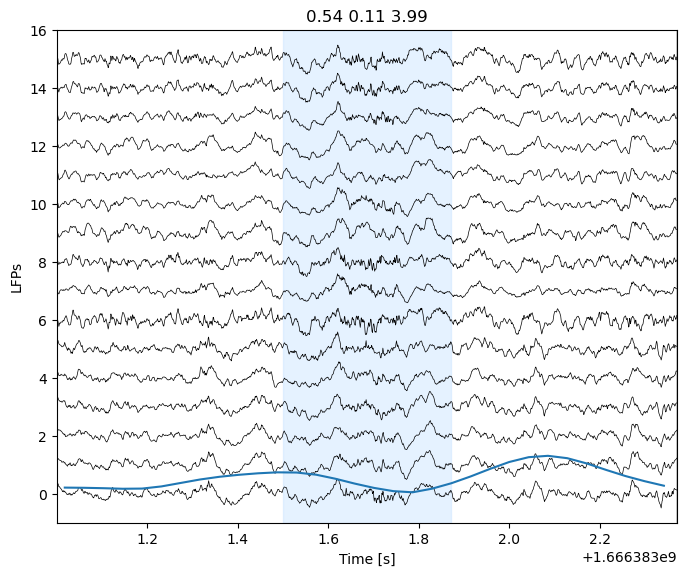

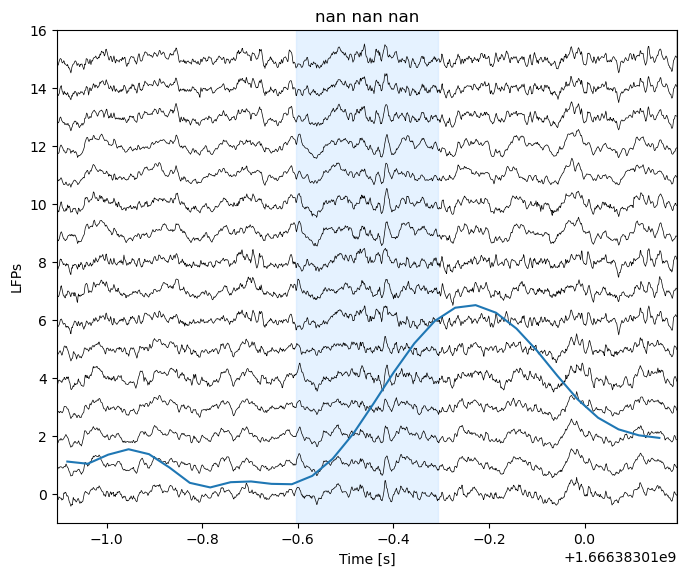

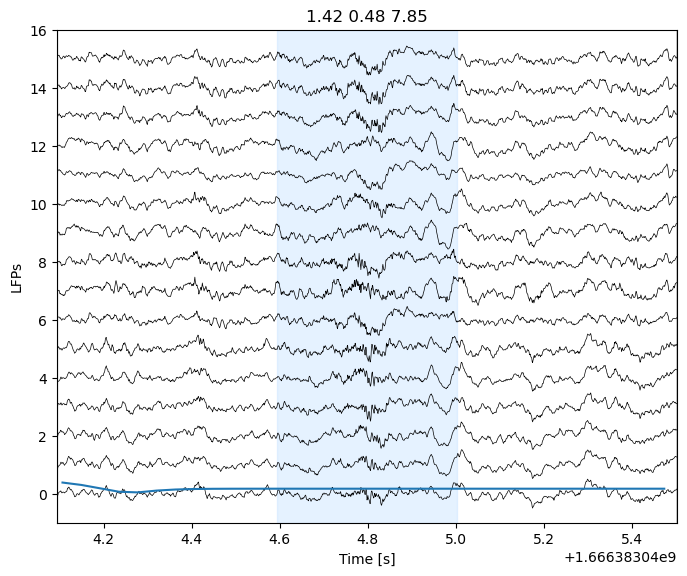

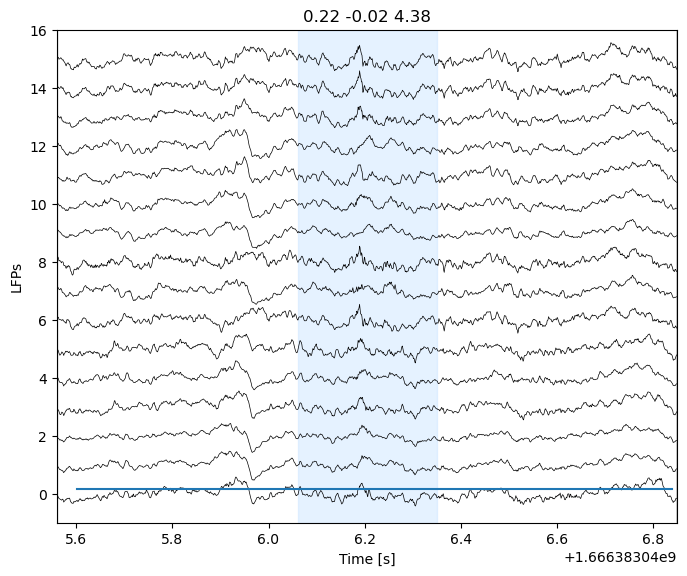

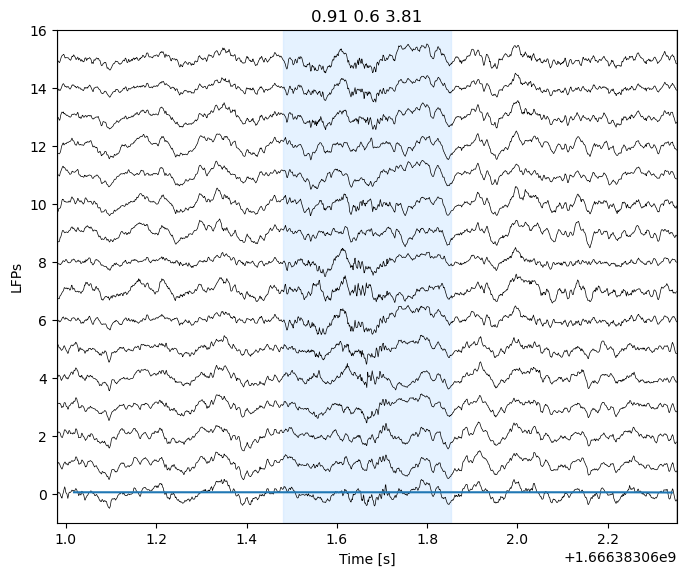

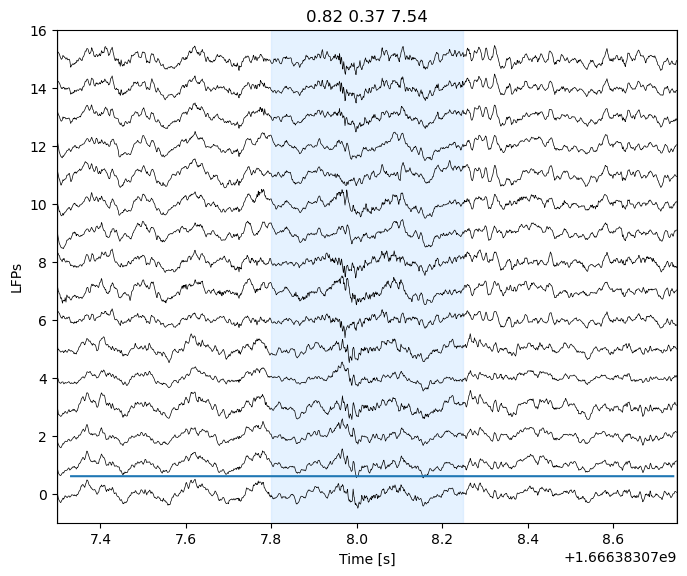

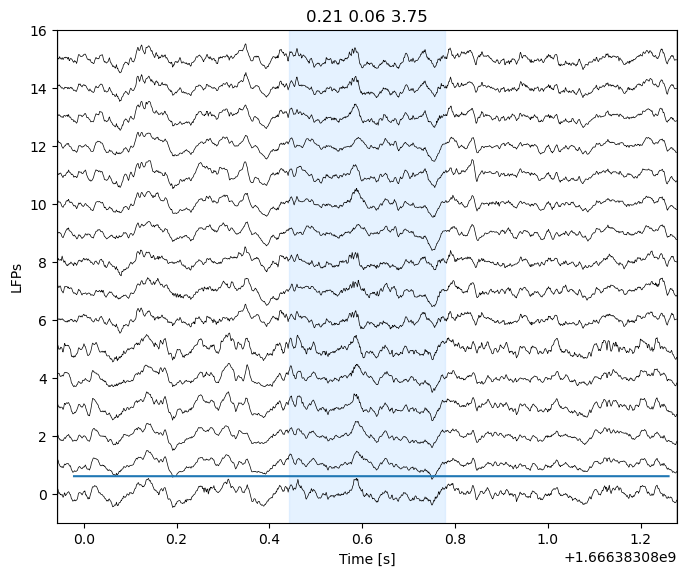

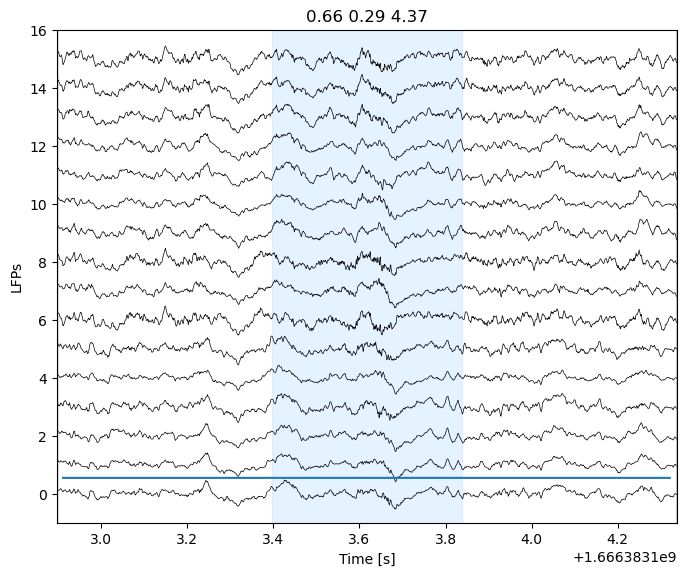

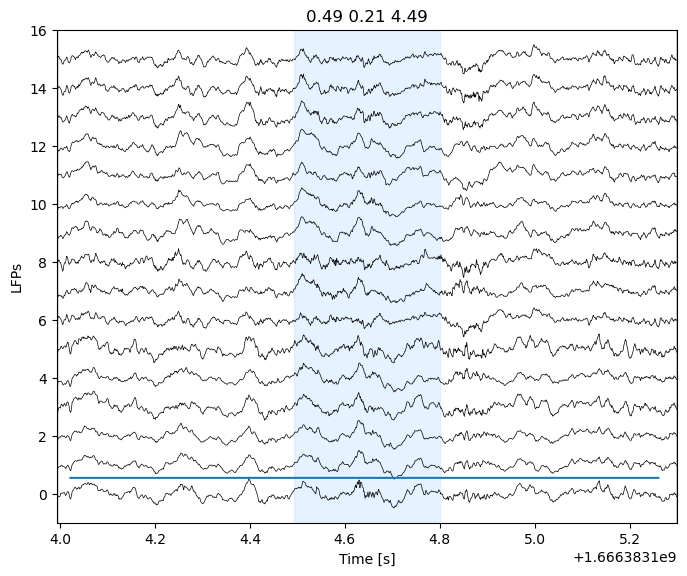

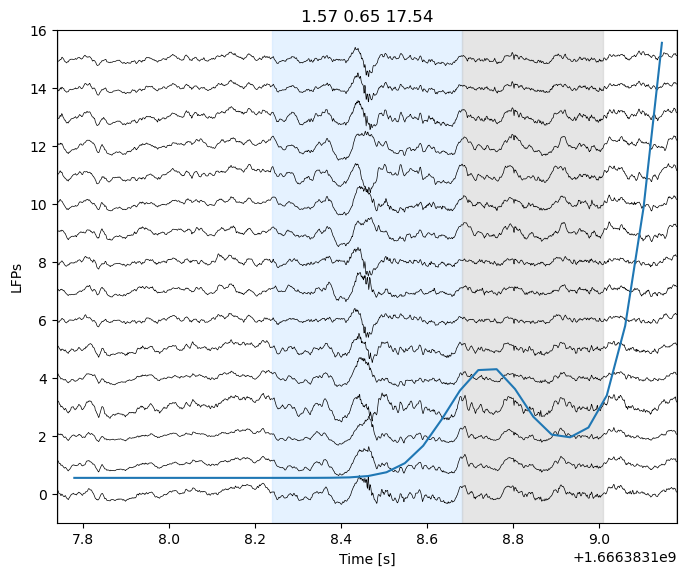

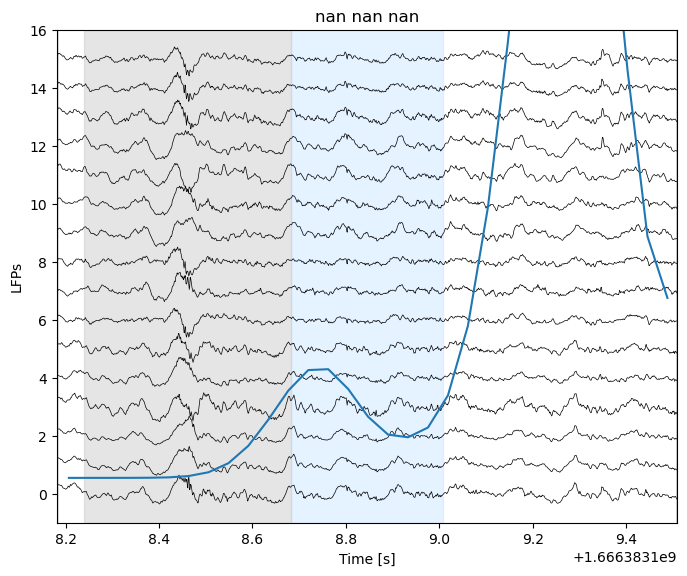

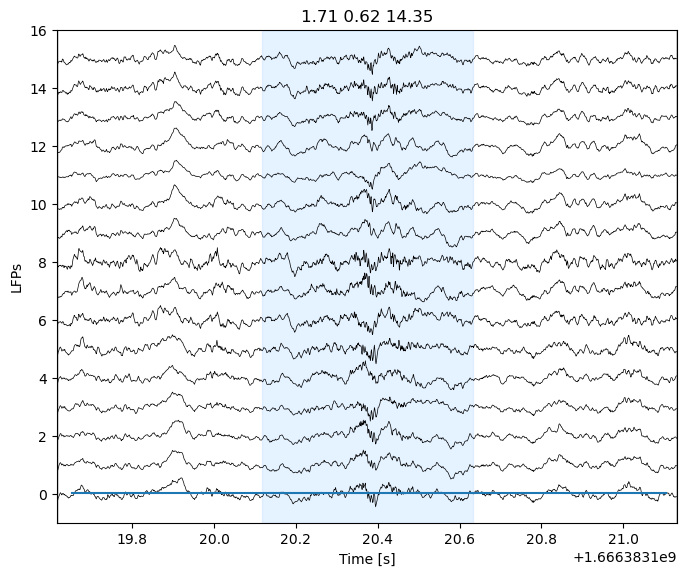

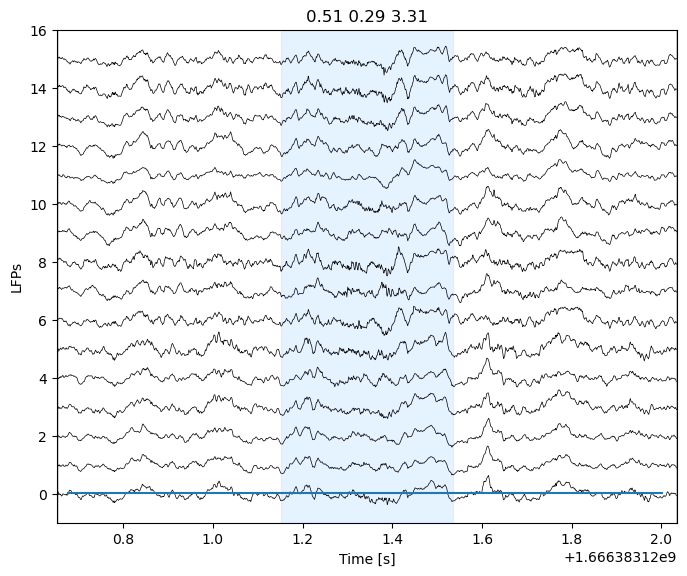

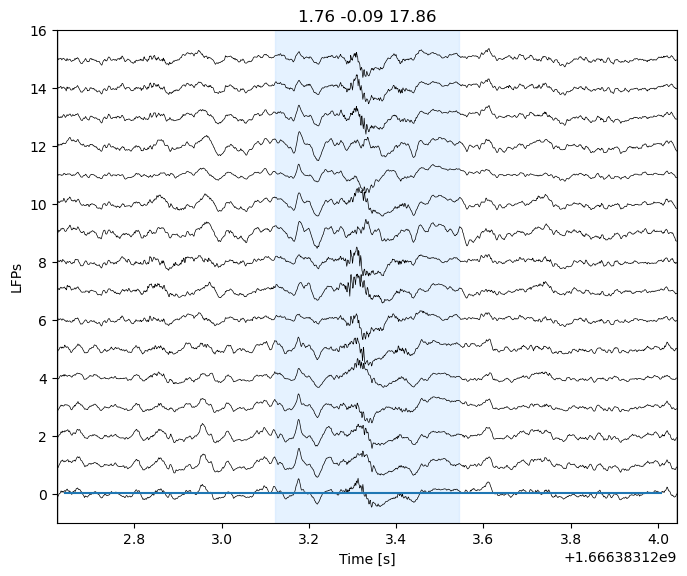

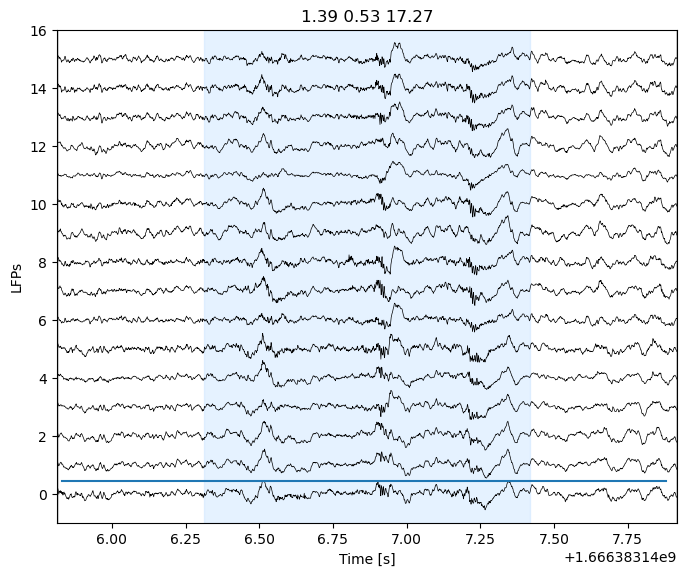

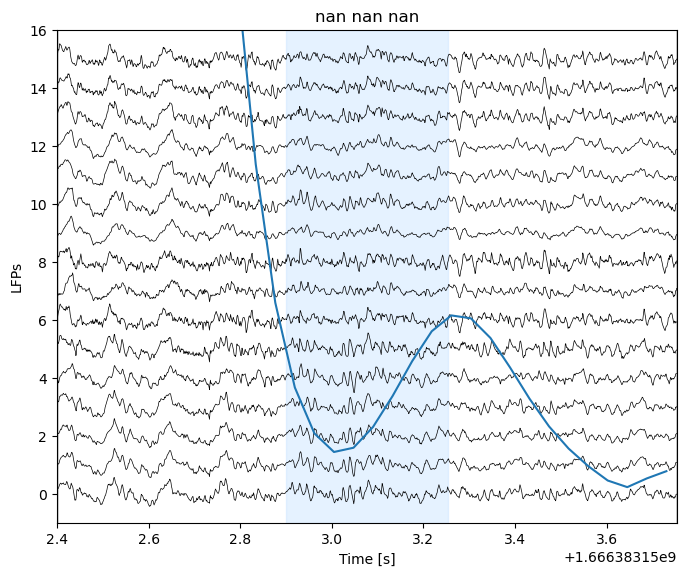

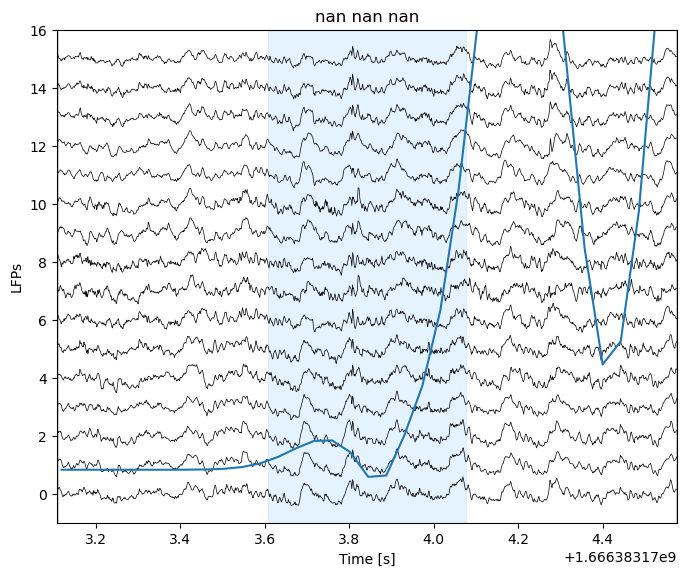

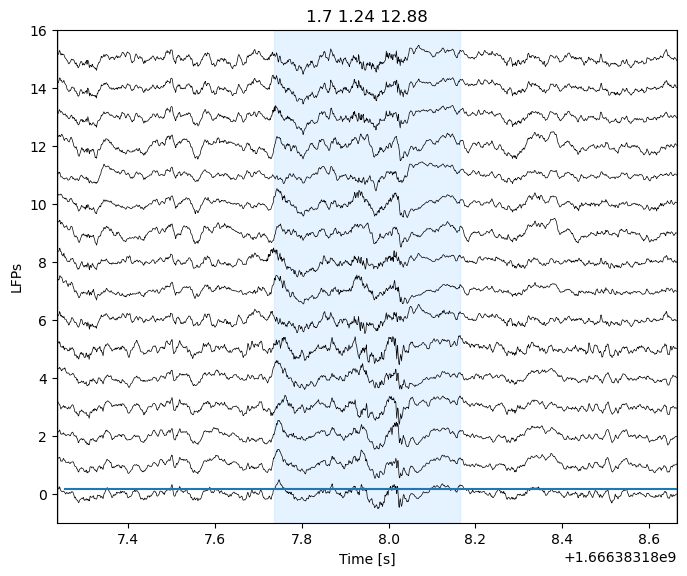

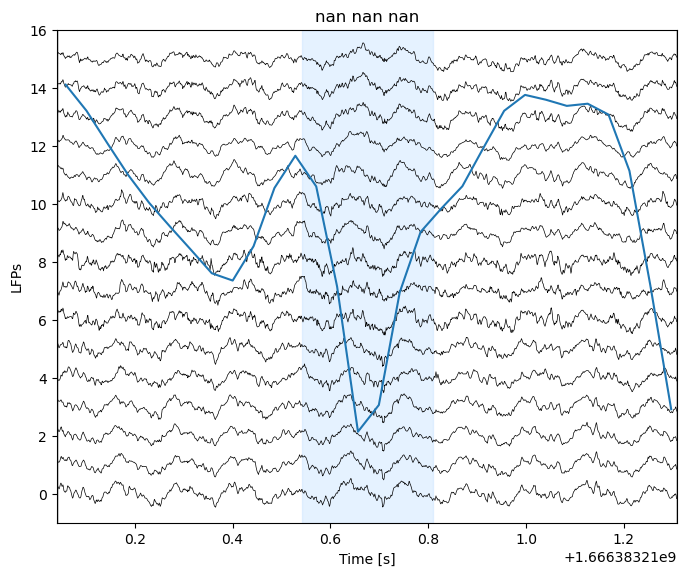

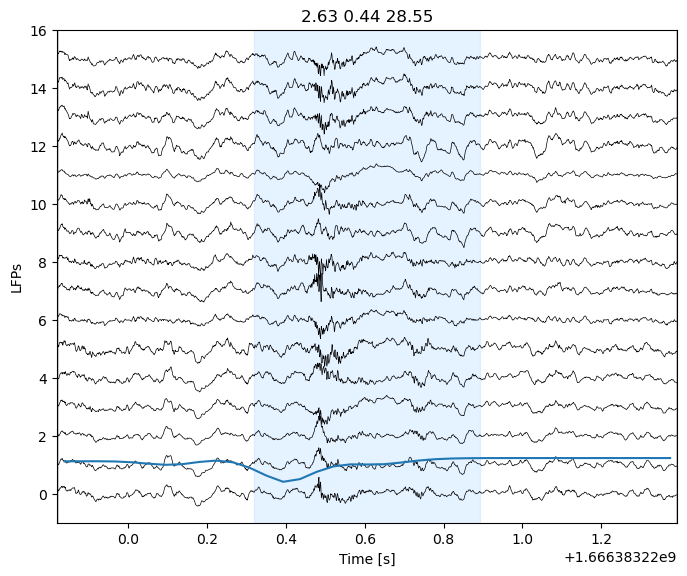

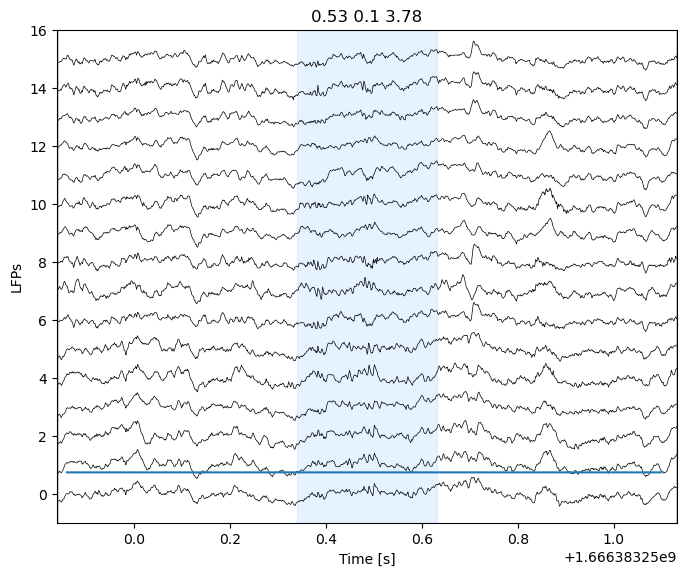

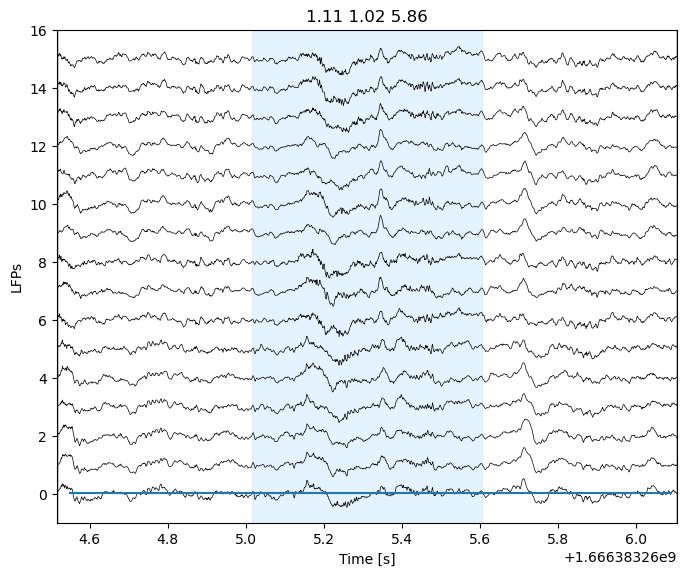

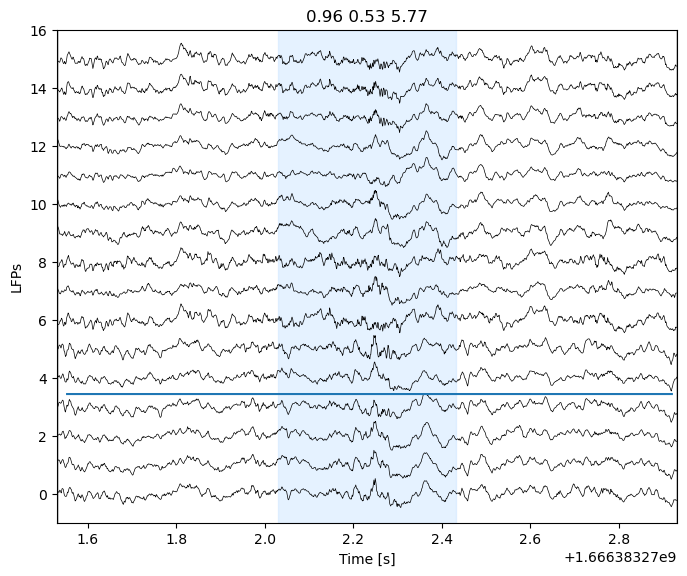

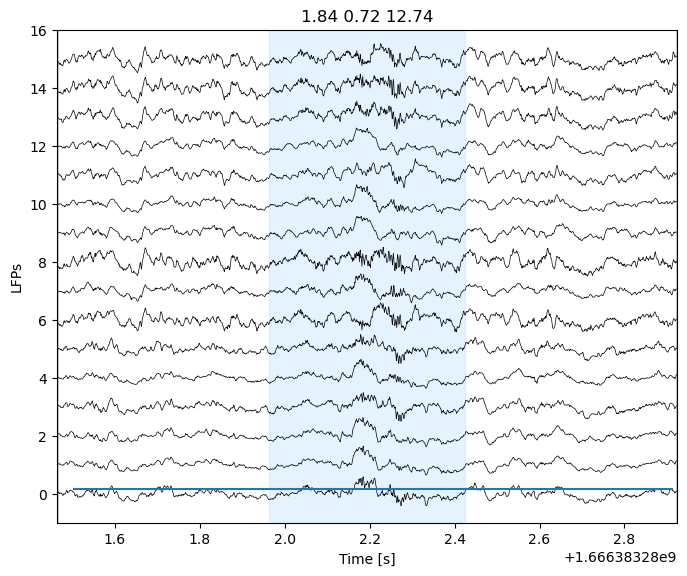

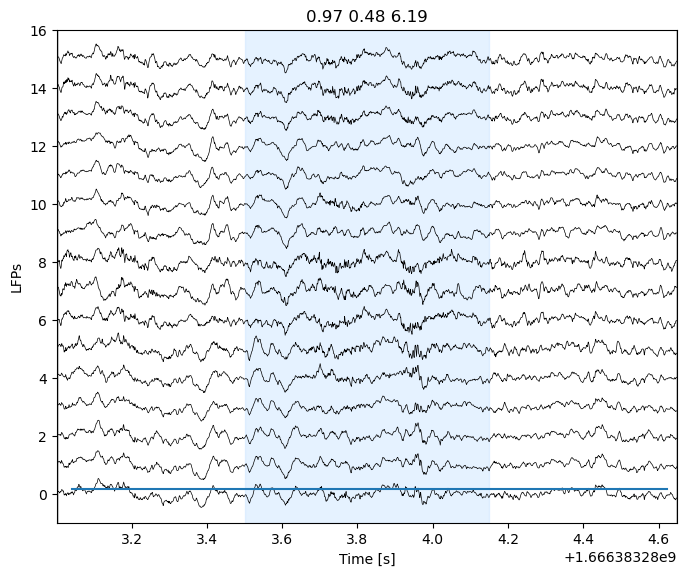

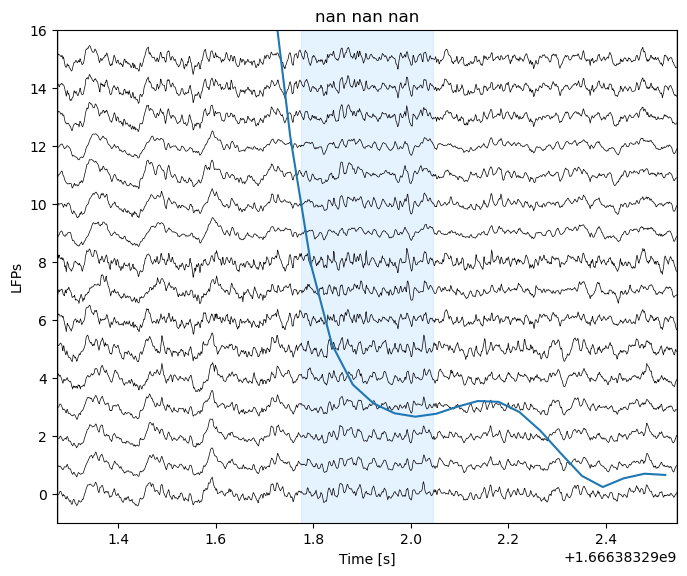

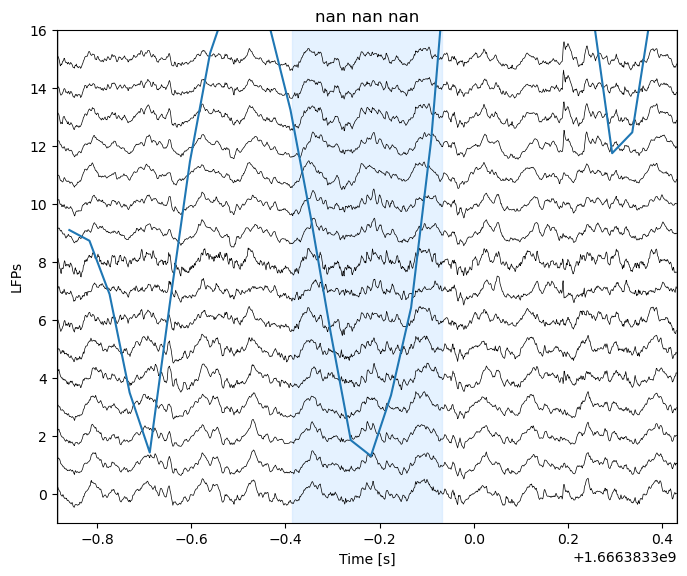

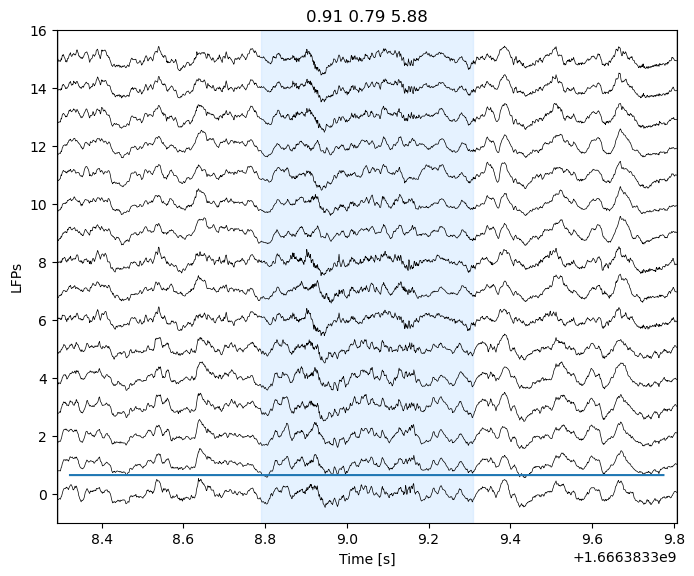

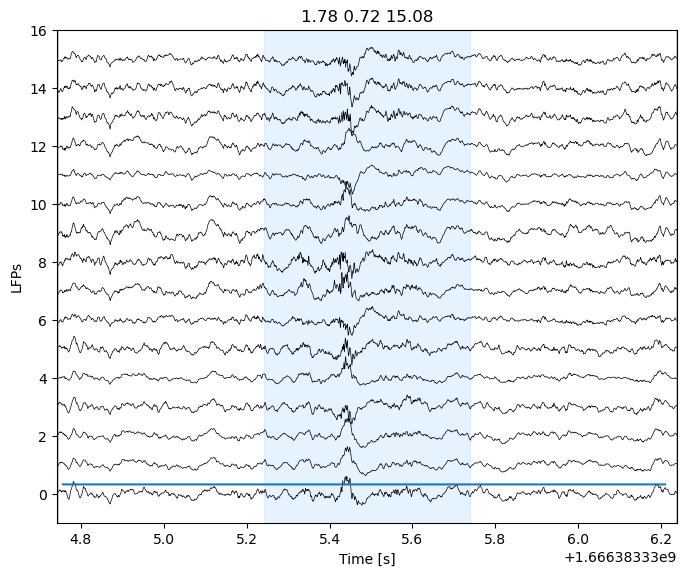

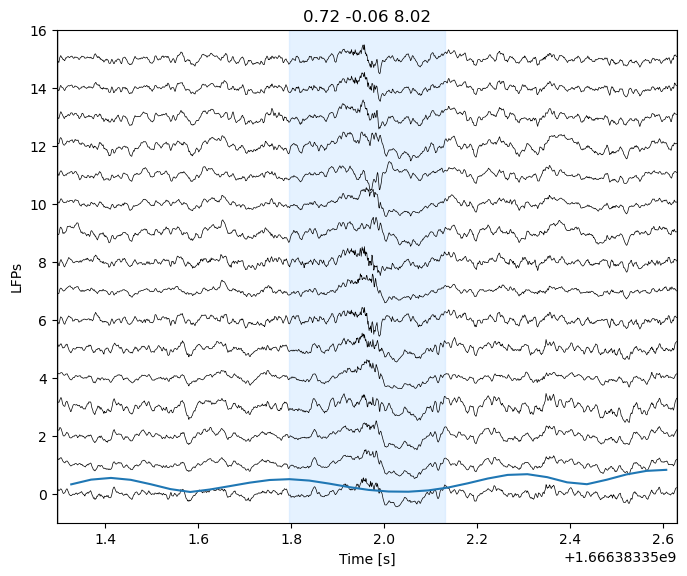

In [114]:
"""plot ripple events"""
offset = 0.5
for r in test.index[:30]:
    #ripple_name = RippleTimes_Karlsson_processed[animal].iloc[r].name
    _,ax = plot_ripple(lfp_df, test,
                ripple_label=r,  offset=offset, relative=False)

    # Add speed into on top
    op = test.loc[r].start_time - offset
    ed = test.loc[r].end_time + offset
    ind = np.logical_and(position_info.index >= op, position_info.index <= ed)
    
    plt.plot(position_info.head_speed[ind])

    ax.set_title(str(round(test.loc[r].mean_zscore,2)) + ' ' +
                 str(round(test.loc[r].median_zscore,2)) + ' ' +str(round(test.loc[r].max_zscore,2)))


### 3. Run all sessions.

In [9]:
epochs_to_run = run_session #epochs#epochs[1:] #if not running the first session

In [10]:
epochs_to_run

[2, 4, 6, 8, 10]

In [11]:
for e in epochs_to_run:
    ripple_times, CA1TetrodeInd, CCTetrodeInd = extended_ripple_detection_master(nwb_file_name,e)
    epoch_name = (EpochPos() & {'nwb_file_name': nwb_copy_file_name ,'epoch':e}).fetch1('epoch_name')

    # for the RippleTimes table
    animal = nwb_copy_file_name[:5]
    savePath=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                      nwb_copy_file_name+'_'+epoch_name+'_extended_ripple_times.csv')
    ripple_times.to_csv(savePath)

    # for the RippleTimes table
    key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}
    key['ripple_times'] = savePath
    ExtendedRippleTimes().insert1(key,replace = True)
    
# to get data out:
# test = (RippleTimes() & {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': epoch_name}).fetch1('ripple_times')
# len(pd.DataFrame(test))

Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 12 15 17 18 24 25 27 28 34 37 39 40 41 43 46 50 52 53
 55 61]


The shape of LFP input is (616266, 23)
Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 12 15 17 18 24 25 27 28 34 37 39 40 41 43 46 50 52 53
 55 61]


The shape of LFP input is (1629135, 23)
Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 12 15 17 18 24 25 27 28 34 37 39 40 41 43 46 50 52 53
 55 61]


The shape of LFP input is (1702515, 23)
Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 12 15 17 18 24 25 27 28 34 37 39 40 41 43 46 50 52 53
 55 61]


The shape of LFP input is (1706394, 23)
Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 12 15 17 18 24 25 27 28 34 37 39 40 41 43 46 50 52 53
 55 61]


The shape of LFP input is (1720683, 23)


In [45]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/pandas/core/missing.py(472)_interpolate_1d()
    470 
    471     # These are sets of index pointers to invalid values... i.e. {0, 1, etc...
--> 472     all_nans = set(np.flatnonzero(invalid))
    473 
    474     first_valid_index = find_valid_index(how="first", is_valid=valid)



ipdb>  exit


In [12]:
ExtendedRippleTimes & {'nwb_file_name': nwb_copy_file_name}

*nwb_file_name *interval_list ripple_tim
+------------+ +------------+ +--------+
molly20220416_ 02_Seq2Session =BLOB=    
molly20220416_ 04_Seq2Session =BLOB=    
molly20220416_ 06_Seq2Session =BLOB=    
molly20220416_ 08_Seq2Session =BLOB=    
molly20220416_ 10_Seq2Session =BLOB=    
 (Total: 5)

### test

In [212]:
ripple_times = pd.read_csv((ExtendedRippleTimes & {'nwb_file_name': nwb_copy_file_name,
                        "interval_list_name":"02_Rev2Session1"}).fetch1("ripple_times"))

In [219]:
ripple_times_decode = pd.read_pickle((ExtendedRippleTimesWithDecode() & {'nwb_file_name':'lewis20240109_.nwb',
                           'interval_list_name':'02_Rev2Session1','decode_threshold_method':'MUA_M05SD'}).fetch1('ripple_times'))

In [274]:
T = pd.DataFrame((ExtendedTrialChoiceReplay() & {'nwb_file_name':'lewis20240109_.nwb',
                           'interval_list_name':'02_Rev2Session1','decode_threshold_method':'MUA_M05SD'}).fetch1("choice_reward_replay"))

In [275]:
all_times = T.loc[30,'ripple_H'][0]

In [294]:
all_times[2,0]-all_times[1,1]

0.21599984169006348

In [238]:
t = 30

In [277]:
arms=T.loc[t,'replay_H'].copy()
ripple_times=T.loc[t,'ripple_H'].copy()

In [278]:
replays_ind=[i for i in range(len(arms)) if len(arms[i])>0]
ripple_times=[ripple_times[i] for i in replays_ind]
arms=[arms[i] for i in replays_ind]

In [279]:
arms

[[[2], [3], [4], [4], [0]], [[0], []]]

In [280]:
ripple_times

[array([[1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09]]),
 array([[1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09]])]

In [281]:
from spyglass.shijiegu.pairwiseDecode import removeEmptyDecode,remove_adjacent

In [282]:
arms, nonemptyInd = removeEmptyDecode(arms)
ripple_times_nonempty = []
for r_ind in range(len(ripple_times)):
    ripple_times_nonempty.append(ripple_times[r_ind][nonemptyInd[r_ind]])

In [283]:
ripple_times_nonempty

[array([[1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09],
        [1.70482842e+09, 1.70482842e+09]]),
 array([[1.70482842e+09, 1.70482842e+09]])]

In [284]:
arms

[[[2], [3], [4], [4], [0]], [[0]]]

In [285]:
ripple_ind_this_trial = 0

In [286]:
ripple_times_ = ripple_times_nonempty[ripple_ind_this_trial]
arms_ = arms[ripple_ind_this_trial]

In [287]:
ripple_times_

array([[1.70482842e+09, 1.70482842e+09],
       [1.70482842e+09, 1.70482842e+09],
       [1.70482842e+09, 1.70482842e+09],
       [1.70482842e+09, 1.70482842e+09],
       [1.70482842e+09, 1.70482842e+09]])

In [288]:
arms_

[[2], [3], [4], [4], [0]]

In [289]:
def merge_overlapping_ranges(ranges):
    '''
    return interals and indices of intervals that got merged
    >>> list(merge_overlapping_ranges([(3.1, 5.3), (4.2, 7.5), (10, 11)]))
    [(3.1, 7.5, 0, 1),(10,11, 2, 2)]
    '''

    ranges =sorted(ranges)
    if len(ranges)==0:
        return []
    current_start, current_stop=ranges[0]
    previous_j=0
    for j in range(len(ranges)):
        start, stop=ranges[j]
        if start>current_stop:
            # Gap between segments: output current segment and start a new
            # one.
            yield current_start, current_stop, previous_j,j-1
            current_start, current_stop = start, stop
            previous_j = j
        else:
            # Segments adjacent or overlapping: merge.
            current_stop = max(current_stop, stop)
    yield current_start, current_stop, previous_j, len(ranges)-1

In [292]:
ripple_times_[:,0]=ripple_times_[:,0]-0.1
ripple_times_[:,1]=ripple_times_[:,1]+0.1

ripple_times_list=[list(a) for a in ripple_times_]
ripple_bouts=list(merge_overlapping_ranges(ripple_times_list))

In [293]:
ripple_bouts

[(1704828420.4504938, 1704828421.9484932, 0, 4)]

In [264]:
bout = ripple_bouts[0]

In [265]:
arms_bout = np.concatenate([arms_[i] for i in np.arange(int(bout[2]),int(bout[3])+1)])

# remove home and center platform
arm_ind=~np.isin(arms_bout,[0,5])
arms_bout=arms_bout[arm_ind]

# remove nans
notnan_ind=~np.isnan(arms_bout)
arms_bout=arms_bout[notnan_ind]

In [266]:
arms_bout

array([2, 3, 4, 4])

In [268]:
arms_bout=np.array(remove_adjacent(list(arms_bout)))

In [269]:
arms_bout

array([2, 3, 4])

In [270]:
for m in range(len(arms_bout)-1):
    i=int(arms_bout[m])
    j=int(arms_bout[m+1])
    print((i,j))

(2, 3)
(3, 4)


In [223]:
ripple_times_decode.loc[59].cont_intvl

array([[1.70482822e+09, 1.70482822e+09],
       [1.70482822e+09, 1.70482822e+09]])

In [226]:
ripple_times_decode.loc[59].cont_intvl_replay

[[4], [2]]

In [227]:
ripple_times_decode.loc[59]

event_number                                                        60
start_time                                           1704828218.368253
animal_location                                                   home
trial_number                                                        23
cont_intvl           [[1704828218.3685317, 1704828218.4625318], [17...
frag_intvl                                                          []
cont_intvl_replay                                           [[4], [2]]
end_time                                             1704828218.647253
duration                                                         0.279
mean_zscore                                                   0.491587
median_zscore                                                -0.033675
max_zscore                                                    6.471125
min_zscore                                                   -0.978429
max_speed                                                     0.878605
min_sp